In [1]:
import sys
import os
sys.path.append('/home/franzi/anzeigendaten/python_base/skillextraktion/fh_ma')
sys.path.append('/home/franzi/anzeigendaten/EnvPython')
import prepare_training_data
from labels import *
import time
import warnings
warnings.filterwarnings('ignore')

from sklearn.utils import shuffle
import numpy as np
np.set_printoptions(precision=3)
%precision 3
start = time.time()
x_train, y_train, x_test, y_test, test_afks, features = prepare_training_data.get_training_data()
print('took: ',time.time()-start)

20861874
0
skipgram, punctuation_marks, stoppwords, multiword, lower_case, vector_dim True False False False False 200
init /home/franzi/Documents/models/no_pm_no_sw/skip_gram_model.model
loading existing w2v model from  /home/franzi/Documents/models/no_pm_no_sw/skip_gram_model.model
using data from  /home/franzi/Documents/data/data_4
loading data...
37076 37076 11806 11806 0 0
took:  6.749361276626587


In [ ]:
import numpy as np
label_y = prepare_training_data.one_hot_to_labels(y_train)

In [4]:
from tensorflow.keras import *

In [5]:
# Build the model
print('Build model...')
model = Sequential()
model.add(layers.LSTM(256, return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2])))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.LSTM(512, return_sequences=True))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.LSTM(256))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256))
model.add(layers.Dense(units=len(labels)))
model.add(layers.Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

batch_size=64
history = model.fit(x_train, y_train, batch_size=batch_size, shuffle=True, epochs=5, validation_data=(x_test, y_test))

2020-08-06 14:01:07 WARNING: From /home/franzi/.local/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Build model...
Train on 37076 samples, validate on 11806 samples


2020-08-06 14:01:10 WARNING: From /home/franzi/.local/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/5
37076/37076 [==============================] - 154s 4ms/sample - loss: 0.8264 - acc: 0.6985 - val_loss: 0.6348 - val_acc: 0.7788
Epoch 2/5
37076/37076 [==============================] - 146s 4ms/sample - loss: 0.5171 - acc: 0.8216 - val_loss: 0.4744 - val_acc: 0.8250
Epoch 3/5
37076/37076 [==============================] - 141s 4ms/sample - loss: 0.4466 - acc: 0.8456 - val_loss: 0.4897 - val_acc: 0.8456
Epoch 4/5
37076/37076 [==============================] - 149s 4ms/sample - loss: 0.4129 - acc: 0.8565 - val_loss: 0.4650 - val_acc: 0.8438
Epoch 5/5
37076/37076 [==============================] - 150s 4ms/sample - loss: 0.3789 - acc: 0.8695 - val_loss: 0.4532 - val_acc: 0.8477


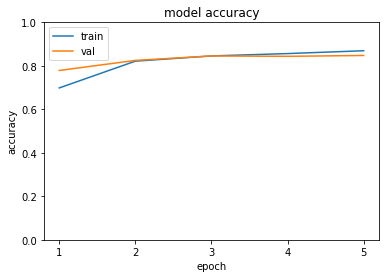

In [6]:
from matplotlib import pyplot as plt
plt.plot(np.arange(1, len(history.history['acc'])+1), history.history['acc'])
plt.plot(np.arange(1, len(history.history['acc'])+1), history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim(0,1)
plt.xticks(np.arange(1, len(history.history['acc'])+1))
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [7]:
# predict test data
y_pred = model.predict(x_test)

In [ ]:
import numpy as np
# convert one hot to labels for test data
pred_label = prepare_training_data.one_hot_to_labels(y_pred)
true_label = prepare_training_data.one_hot_to_labels(y_test)

print('class distribution test data + predicted')
print('-----------------------------------')
for i, label in enumerate(labels):
    print(i,label,':',np.sum(true_label==i), 'pred: ',np.sum(pred_label==i))

In [9]:
# Calc metrics for test data
import sklearn
from sklearn.metrics import precision_score, recall_score
from tabulate import tabulate
label_list = list(labels.keys())

headers = [l for l in label_list ]
headers = [' '] + headers

table=[['precision'] + list(precision_score(true_label, pred_label, average=None)), 
       ['recall']+list(recall_score(true_label, pred_label, average=None)), 
       ['f1']+ list(sklearn.metrics.f1_score(true_label, pred_label, average=None))]

print(tabulate(table, headers=headers, tablefmt='orgtbl'))
f1 = sklearn.metrics.f1_score(true_label, pred_label, average=None)
f1 = np.delete(f1, 4)
f1 = np.delete(f1, 6)
print('f1 average: ',sum(sklearn.metrics.f1_score(true_label, pred_label, average=None))/len(list(precision_score(true_label, pred_label, average=None))))
print('f1 average: ',sum(f1)/6)
print('Precision average: ',sum(precision_score(true_label, pred_label, average=None)/8))
print('recall average: ',sum(recall_score(true_label, pred_label, average=None)/8))
print('acc', sklearn.metrics.accuracy_score(true_label, pred_label))

|           |   Ausbildung |    Beruf |   allgemein |   berufsspez |   Sprache |   Technologie |   Softskill |   noSkill |
|-----------+--------------+----------+-------------+--------------+-----------+---------------+-------------+-----------|
| precision |     0.726375 | 0.75     |    0.523397 |     0.612177 |  0.97235  |      0.760797 |    0.825592 |  0.936221 |
| recall    |     0.934664 | 0.140625 |    0.422969 |     0.68791  |  0.954751 |      0.886452 |    0.810987 |  0.909946 |
| f1        |     0.81746  | 0.236842 |    0.467854 |     0.647838 |  0.96347  |      0.818832 |    0.818225 |  0.922896 |
f1 average:  0.7116771758956831
f1 average:  0.6345084766353489
Precision average:  0.7633637217918252
recall average:  0.7185379594307035
acc 0.8477045570049128


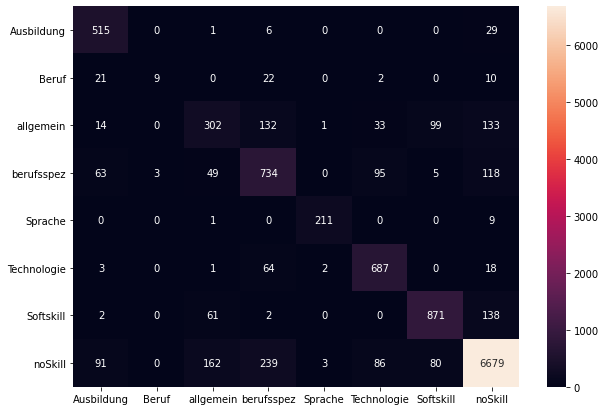

In [10]:
# Create Confusion Matrix

import sklearn
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

cm = sklearn.metrics.confusion_matrix(true_label, pred_label)
df_cm = pd.DataFrame(cm, labels,columns = labels)
plt.figure(figsize = (10,7))
plt.ylabel('Eingabe')
plt.xlabel('Ausgabe')
sn.heatmap(df_cm, annot=True,fmt='g')

In [11]:
# clean noSkill for evaluation
clean_y_pred = []
clean_y_test = []
true_noSkills = 0
clean_x_test = []
afks = []

for i in range(len(y_test)):
    if(true_label[i] != 7 or pred_label[i] != 7):
        clean_x_test.append(x_test[i])
        clean_y_pred.append(pred_label[i])
        clean_y_test.append(true_label[i])
        afks.append(test_afks[i])
    else:
        true_noSkills += 1
pred_label = clean_y_pred
true_label = clean_y_test
print('correctly labeled noSkills: ', true_noSkills)

correctly labeled noSkills:  6679


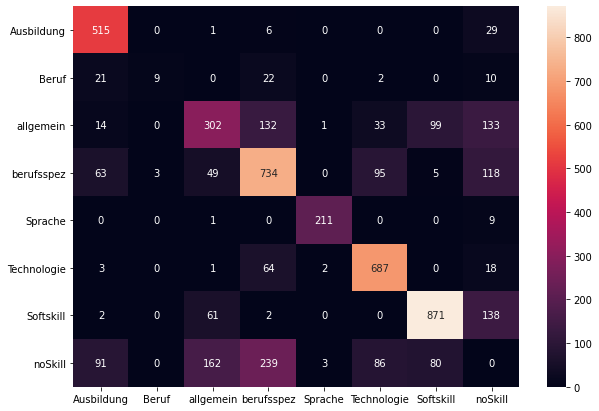

In [12]:
# Create Confusion Matrix

import sklearn
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

cm = sklearn.metrics.confusion_matrix(true_label, pred_label)
df_cm = pd.DataFrame(cm, labels,columns = labels)
plt.figure(figsize = (10,7))
plt.ylabel('Eingabe')
plt.xlabel('Ausgabe')
sn.heatmap(df_cm, annot=True,fmt='g')